# Quick start

Let's set up a simple emulator for scattering of 28 MeV protons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction.

In [6]:
import numpy as np
import rose
from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
from matplotlib import colormaps as cm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams["text.latex.preamble"] = (
    r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
)
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [8]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 48
Z = 20

# lab bombarding energy
E_lab = 28  # MeV

# get kinematics and default KD params
mu, E_com, k, eta = rose.utility.kinematics((A,Z), (1,1), E_lab=E_lab)
omp = rose.koning_delaroche.KDGlobal(Projectile.proton)
R_C, parameters = omp.get_params(A, Z, mu, E_com, k)

In [20]:
# take train and test parameter samples from a box bounded
# 50% above and below the default values
scale = 0.25

bounds = np.array(
    [
        parameters - np.fabs(scale * parameters),
        parameters + np.fabs(scale * parameters),
    ]
).T

In [21]:
from rose.training import sample_params_LHC

# sample points for a train/test split
# sample from +/-50% around the default params using Latin hypercube
n_test = 20
n_train = 80
train = sample_params_LHC(n_train, parameters, scale, seed=13)
test = sample_params_LHC(n_test, parameters, scale, seed=721)

Instantiate the set of interactions for each partial wave. We use the type `InteractionEIMSpace` because we will use the Empirical Interpolation Method (EIM) to handle potentials that are non-affine (like the Woods-Saxon forms in Koning-Delaroche). We will not discuss this here, for more detail, see the following tutorials.

In [22]:
interactions = rose.InteractionEIMSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=len(parameters),
    mu=mu,
    energy=E_com,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    training_info=bounds,
    Z_1=1,
    Z_2=13,
    R_C=R_C,
    n_basis=20,  # we will choose 20 basis elements out of a hat for now
)

Now that we have our `InteractionSpace` set up, we can construct a `ScatteringAmplitudeEmulator`, which trains and runs the emulator for us. We will pass in our set of training points and our angular mesh, and choose a number of basis elements that is the dimension of our reduced basis. In general, this number should be much smaller than the number of training points; increasing it will lead to a more accurate, albeit slower, emulator. In the following tutorial, we will optimize this, amongst other, parameters, to achieve a given accuracy and speedup goal. For now, however, we will choose an ad-hoc basis size of 10, which, it will turn out, will give us a very accurate and fast emulator.

In [23]:
# set up and train emulator using sensible defaults
base_solver = rose.SchroedingerEquation.make_base_solver(
    s_0=6 * np.pi, rk_tols=[1e-10, 1e-10], domain=np.array([1e-8, 8 * np.pi])
)
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    train,
    n_basis=15,  # we will just choose 15 out of a hat for now, more on this later
    angles=np.linspace(np.pi / 181, np.pi, 180),
    base_solver=base_solver,
    scale=True,
    use_svd=True,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:08<00:00, 11.79s/it]


It's as simple as that, now we have a trained emulator we can use to calculate cross sectons! Let's compare observables between the emulator and the high-fidelity solver using our test set of sampled parameters. We will do this by calling the functions `emulate_xs` and `exact_xs` on our emulator, passing in a set of parameters from our test set.

In [24]:
%%time

# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append(emulator.exact_xs(sample))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:38<00:00,  1.91s/it]

CPU times: user 38.4 s, sys: 550 ms, total: 39 s
Wall time: 38.3 s


In [25]:
len(emulator.rbes[1])

2

In [26]:
%%time

# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append(emulator.emulate_xs(sample))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 134.11it/s]

CPU times: user 363 ms, sys: 679 ms, total: 1.04 s
Wall time: 151 ms


Now let's plot the results!

Text(0, 0.5, '$\\sigma / \\sigma_{\\rm{Rutherford}}$ ')

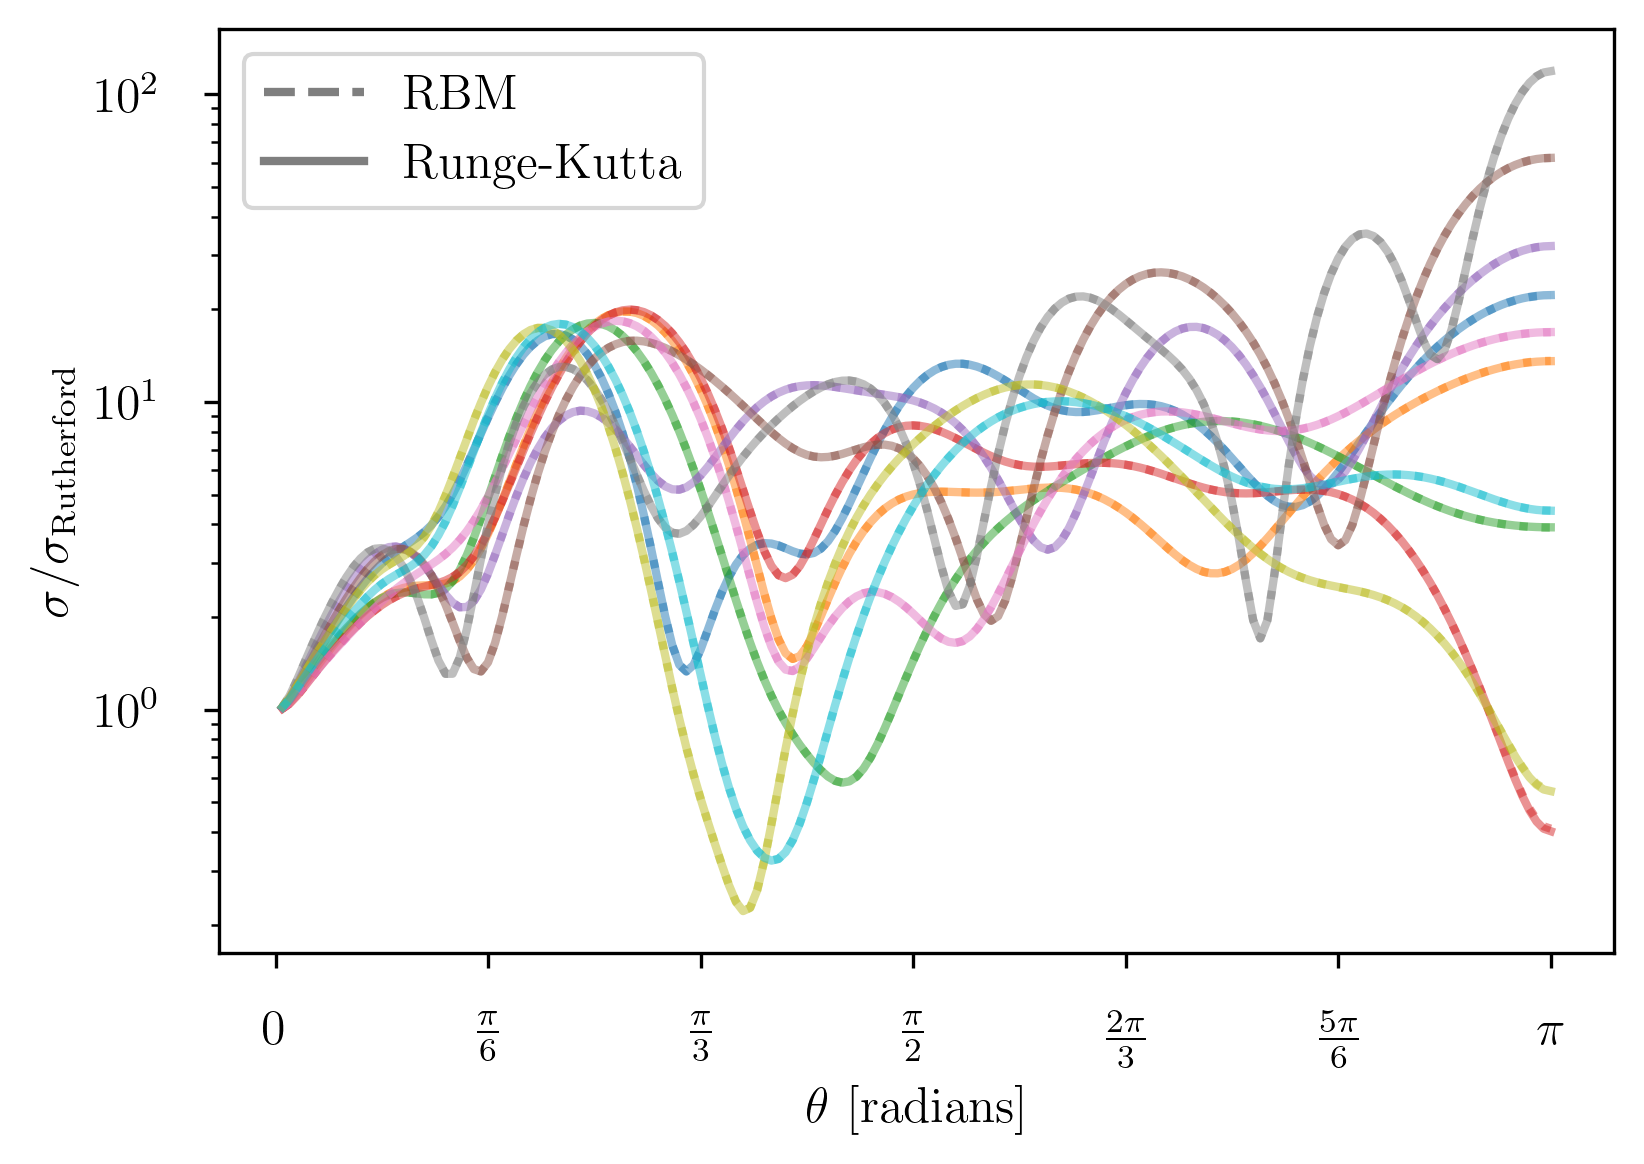

In [27]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[::2]):
    x = emulator.angles

    # HIFI
    y_exact = HIFI_xs[i].dsdo

    # emulated
    y_emu = emu_xs[i].dsdo

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.set_yscale("log")
plt.xlabel(r"$\theta$ [radians]", fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

plt.ylabel(r"$\sigma / \sigma_{\rm{Rutherford}}$ ", fontsize=12)

Text(0, 0.5, '$A_y(\\theta)$ ')

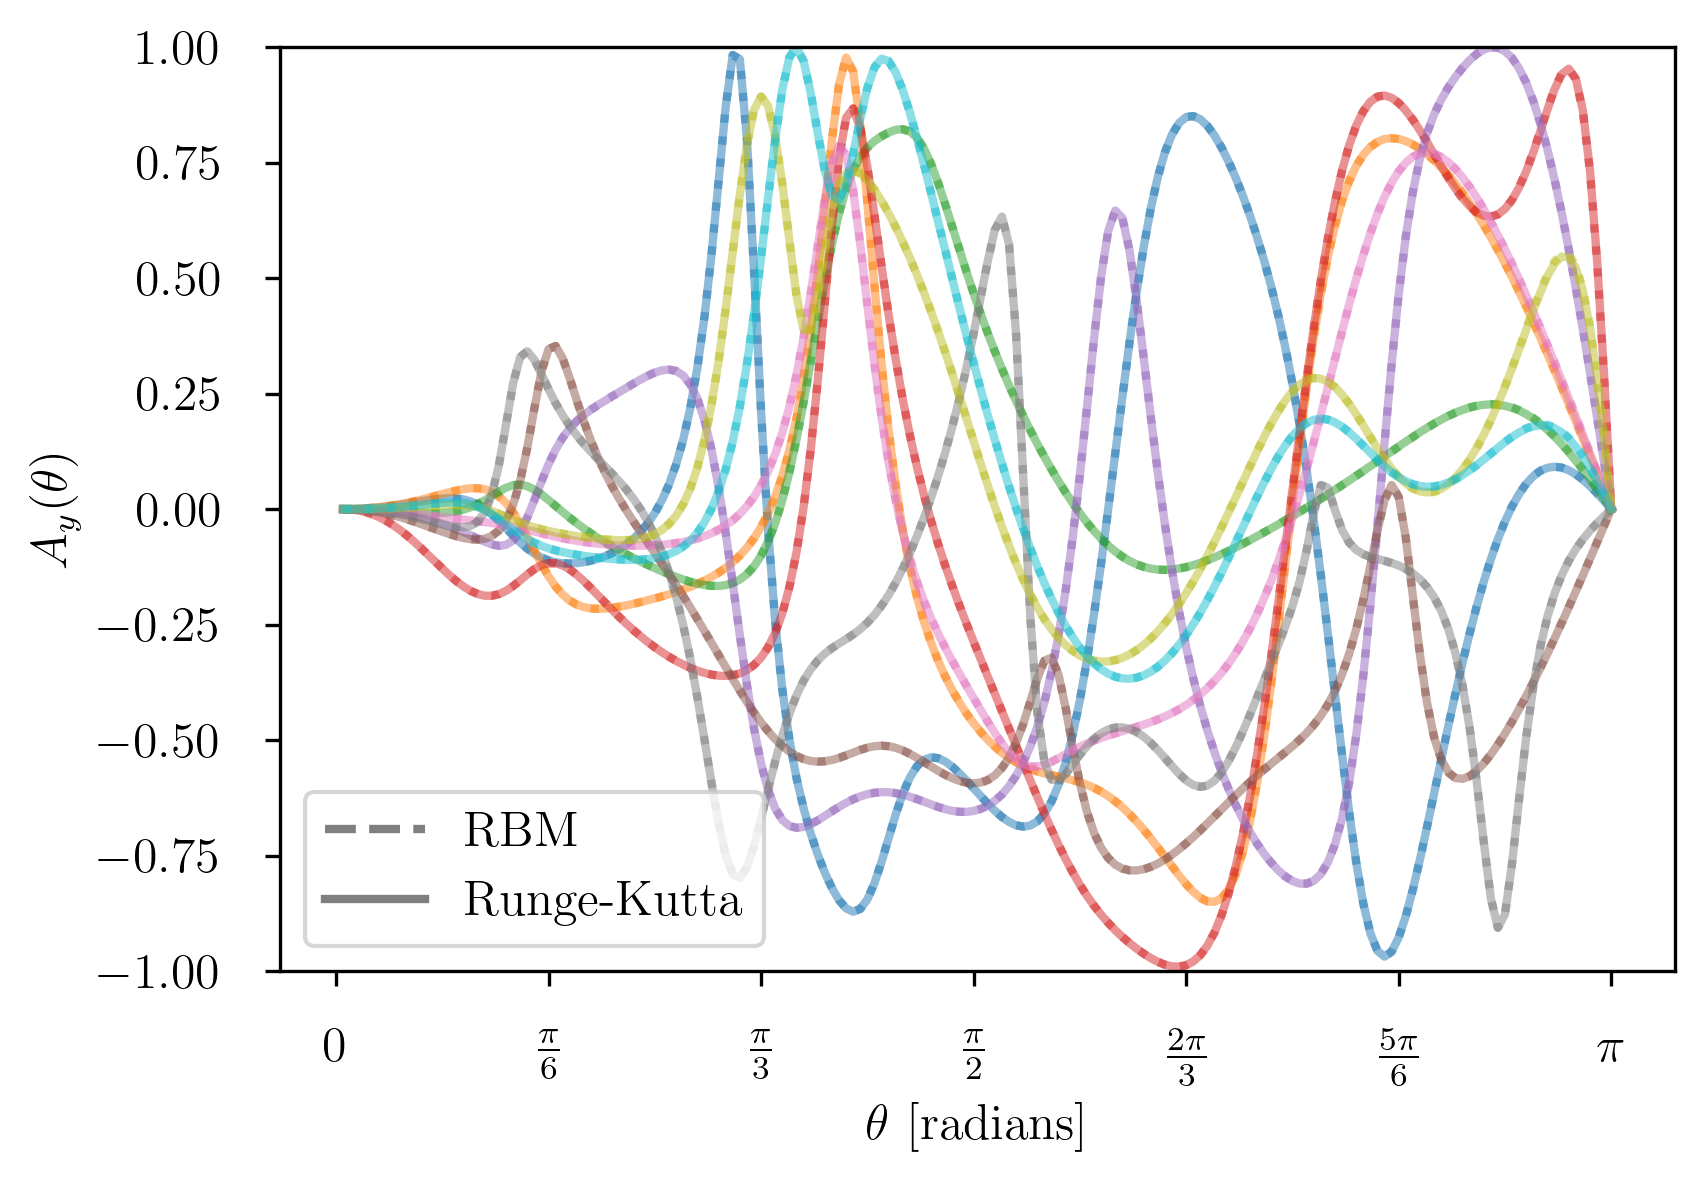

In [28]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[::2]):
    x = emulator.angles

    # HIFI
    y_exact = HIFI_xs[i].Ay

    # emulated
    y_emu = emu_xs[i].Ay

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.set_ylim([-1, 1])
plt.xlabel(r"$\theta$ [radians]", fontsize=12)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

plt.ylabel(r"$A_y(\theta)$ ", fontsize=12)

Isn't that nice, the emulated and high-fidelity observables are right on top of eachother! The following series of tutorials will walk through how to choose the the optimal hyper-parameters (like the basis size), and demonstrate linking to `surmise` for fast Bayesian uncertainty quantification!